### Isolation Forest for Time-Series Anomaly Detection 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import moment, skew, kurtosis
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix

#### Data preprocessing

In [3]:
# raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv")
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


Anomalies labeled according to the NAB github (https://github.com/numenta/NAB/blob/master/labels/):

In [4]:
data['anomaly'] = 0 # 1 = anomaly, 0 = normal
instances_of_anomaly_machine = [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
                                ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
                                ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
                                ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]

instances_of_anomaly_nyc_taxi = [["2014-10-30 15:30:00.000000",
                                  "2014-11-03 22:30:00.000000"],
                                 [
                                 "2014-11-25 12:00:00.000000",
                                 "2014-11-29 19:00:00.000000"],
                                 [
                                 "2014-12-23 11:30:00.000000",
                                 "2014-12-27 18:30:00.000000"],
                                 [
                                 "2014-12-29 21:30:00.000000",
                                 "2015-01-03 04:30:00.000000"],
                                 [
                                 "2015-01-24 20:30:00.000000",
                                 "2015-01-29 03:30:00.000000"]]

# Marking the instances of anomaly in the dataset
for instance in instances_of_anomaly_nyc_taxi: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'anomaly'] = 1

Plot the data with anomalies marked

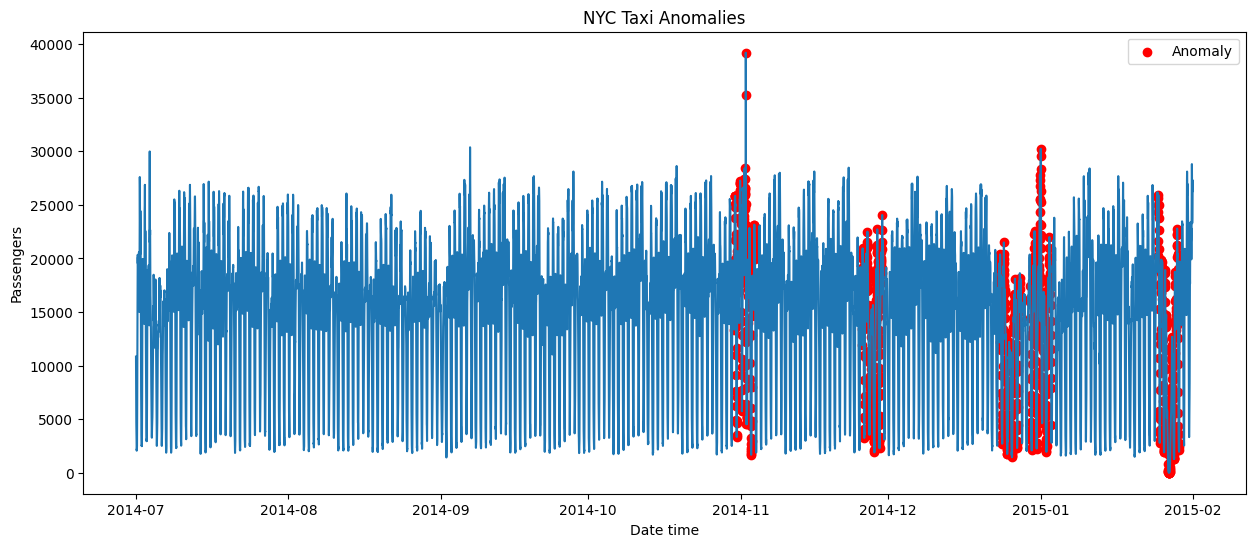

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(data['timestamp'], data['value'])
plt.scatter(data['timestamp'][data['anomaly'] == 1], data['value'][data['anomaly'] == 1], color='red', label='Anomaly')
# plt.title('Machine Temperature System Failure')
plt.title('NYC Taxi Anomalies')
plt.xlabel('Date time')
# plt.ylabel('Temperature')
plt.ylabel('Passengers')
plt.legend()
plt.show()

#### Split data into training, validation and testing sets
60% training, 20% validation and 20% testing

In [6]:
data_train = data[0:int(len(data)*0.6)]
data_val = data[int(len(data)*0.6):int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

labels_train = data_train['anomaly']
labels_val = data_val['anomaly']
labels_test = data_test['anomaly']

X_train = data_train.drop(['anomaly'], axis=1)
X_val = data_val.drop(['anomaly'], axis=1)
X_test = data_test.drop(['anomaly'], axis=1)

contamination_coef = sum(labels_train) / len(labels_train)

Normalize the data according to the training set

In [7]:
mean = X_train['value'].mean()
std = X_train['value'].std()
X_train['value'] = (X_train['value'] - mean) / std
X_val['value'] = (X_val['value'] - mean) / std
X_test['value'] = (X_test['value'] - mean) / std

#### Model

Extract features from time series data

In [8]:
def extract_features(time_series, window_size):
    features = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i:i+window_size]
        mean = np.mean(window)
        std_dev = np.std(window)
        skewness = moment(window, moment=3)
        kurtosis_val = moment(window, moment=4)
        autocorr_lag1 = acf(window, fft=False)[1]  # Autocorrelation at lag 1
        fourier_coeffs = np.abs(fft(window))[:window_size//2]  # Fourier transform coefficients (amplitudes)
        
        feature_vector = [mean, std_dev, skewness, kurtosis_val , autocorr_lag1]
        feature_vector.extend(fourier_coeffs)
        
        features.append(feature_vector)
    
    return np.array(features)

In [9]:
window_size = 100
X_train_features = extract_features(np.array(X_train['value']), window_size)
X_val_features = extract_features(np.array(X_val['value']), window_size)
X_test_features = extract_features(np.array(X_test['value']), window_size)

Train Isolation Forest model

Contamination parameter sets the proportion of anomalies expected in the data

In [10]:
model = IsolationForest(contamination=contamination_coef)
model.fit(X_train_features)

IsolationForest(contamination=0.03343023255813953)

In [11]:
# Predict anomaly scores
anomaly_scores = model.decision_function(X_val_features)

In [24]:
# Threshold for classifying instances as anomalies (adjust as needed)
threshold = np.percentile(anomaly_scores, 95)

In [25]:
# Classify instances as normal (0) or anomalous (1)
predictions = np.where(anomaly_scores >= threshold, 0, 1)

In [26]:
def assign_point_predictions(window_predictions, window_size):
    point_predictions = np.append(window_predictions, np.full(window_size-1, window_predictions[-1]))
    return point_predictions

In [27]:
point_predictions = assign_point_predictions(predictions, window_size)

In [28]:
# Output predictions
print("Predictions:", predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_val, point_predictions)
conf_matrix = confusion_matrix(labels_val, point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [1 1 1 ... 1 1 1]
Accuracy: 0.14825581395348839
Confusion Matrix:
[[  99 1758]
 [   0  207]]


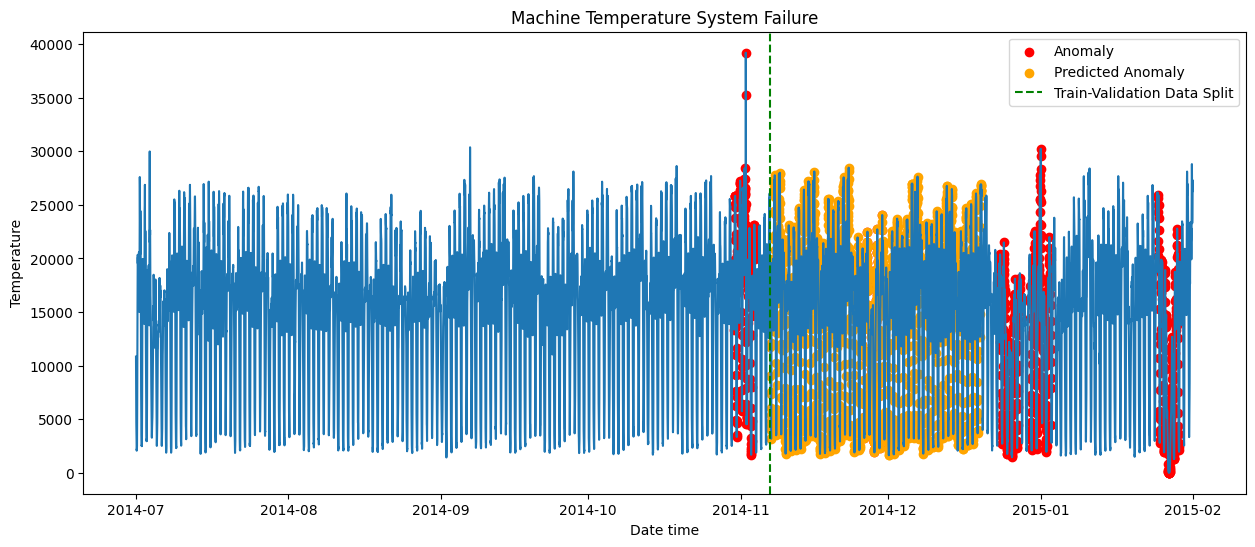

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(data['timestamp'], data['value'])
plt.scatter(data['timestamp'][data['anomaly'] == 1], data['value'][data['anomaly'] == 1], color='red', label='Anomaly')
plt.scatter(data_val['timestamp'][point_predictions == 1], data_val['value'][point_predictions == 1], color='orange', label='Predicted Anomaly')
plt.title('Machine Temperature System Failure')
plt.xlabel('Date time')
plt.ylabel('Temperature')
plt.axvline(data_val['timestamp'].iloc[0], color='green', linestyle='--', label='Train-Validation Data Split')
# plt.axvline(data_test['timestamp'].iloc[0], color='blue', linestyle='--', label='Validation-Test Data Split')
plt.legend()
plt.show()